In [1]:
import numpy as np
import pandas as pd
import pickle, os, csv, math, time, joblib
from joblib import Parallel, delayed
import datetime as dt
from datetime import date, datetime, timedelta
from collections import Counter
import copy as cp
import tqdm
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import collections 
#import shap
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
np.seterr(all="ignore")
import matplotlib.pyplot as plt

# Simulation
* Simulate RL data from two different distributions, generate transition tuples

In [2]:
# Generate transition matrices, separate distributions for each one
shape, scale = 2., 1. 
transition_foreground = np.random.gamma(shape, scale, (12, 10))

mu, sigma = 0, 0.1 # mean and standard deviation
transition_background = np.random.normal(mu, sigma, (12, 10))

In [3]:
# Generate reward function
mu, sigma = 0, 2
reward_function = np.random.normal(mu, sigma, (12, 1))

In [4]:
# Params
exploit = 0.8
explore = 1-exploit
num_samples = 10000
actions = [[0, 0], [0, 1], [1, 0], [1, 1]]
mu, sigma = 0, 1

In [5]:
transition_tuples = []
for i in range(num_samples):
    # All initial states are generated from random normal
    s = np.random.normal(mu, sigma, (10, 1))
    
    flip = random.uniform(0, 1)
    # Exploit
    if flip < exploit:
        # Decide which transition matrix
        flip = np.random.choice(1)
        
        all_rewards = []
        for j, a in enumerate(actions):
            a = np.asarray(a)
            a = np.reshape(a, (2, 1))
            s_a = np.concatenate((s, a))
            reward = np.dot(reward_function.T, s_a)
            all_rewards.append(reward)
        
        noise = np.random.normal(0, 0.01, 1)
        all_rewards = np.asarray(all_rewards)
        a = actions[np.argmax(all_rewards)]
        reward = np.max(all_rewards) + noise
        
        if flip == 0:
            ns = np.dot(s_a.T, transition_foreground) 
        else:
            ns = np.dot(s_a.T, transition_background) 
        ns = np.add(ns , np.random.normal(0, 0.01, (1, 10))) # Add noise
    # Explore
    else:
        a = np.asarray(actions[np.random.choice(3)])
        a = np.reshape(a, (2, 1))
        s_a = np.concatenate((s, a)) # concatenate the state and action
        
        # Decide which transition matrix
        flip = np.random.choice(1)
        if flip == 0:
            ns = np.dot(s_a.T, transition_foreground)
        else:
            ns = np.dot(s_a.T, transition_background)
        reward = np.dot(reward_function.T, s_a) + np.random.normal(0, 0.01, 1)
        ns = np.add(ns , np.random.normal(0, 0.01, (1, 10))) # Add noise
    
    # Transition tuple includes state, action, next state, reward, indication of foreground/background
    # 1 if foreground 0 if background
    transition_tuples.append((s, list(a), ns, reward, 1 - flip, i))

In [6]:
split = int(0.8*len(transition_tuples))
train_tuples = transition_tuples[:split]
test_tuples = transition_tuples[split:]

In [7]:
train = {}
test = {}
elts = ['s', 'a', 'ns', 'r', 'ds', 'vnum']
for elt in elts:
    train[elt] = []
    test[elt] = []

for tup in train_tuples:
    train['s'].append(tup[0].flatten())
    a = tup[1]
    try:
        a = np.concatenate(a).ravel()
        a = list(a)
        train['a'].append(a)
    except:
        train['a'].append(a)
    train['ns'].append(tup[2].flatten())
    train['r'].append(tup[3])
    train['ds'].append(tup[4])
    train['vnum'].append(tup[5])

for tup in test_tuples:
    test['s'].append(tup[0].flatten())
    try:
        a = tup[1]
        a = np.concatenate(a).ravel()
        a = list(a)
        test['a'].append(a)
    except:
        test['a'].append(tup[1])
    test['ns'].append(tup[2].flatten())
    test['r'].append(tup[3])
    test['ds'].append(tup[4])
    test['vnum'].append(tup[5])

In [8]:
train['s'][0]

array([ 2.20679845, -0.1169956 ,  1.00830122,  1.07942742, -0.14971577,
        1.05451915,  0.98075563,  0.50213052, -0.71058332,  0.69725792])

# FQI

* Fit vanilla FQI algorithm, with linear regression on both data
* Do mixed model linear contrastive case
* What do we expect when we validate it?

In [9]:
# Define action space, the potential classes of action items. 
def a2c(action):
    actions = [[0, 0], [0, 1], [1, 0], [1, 1]]
    classes = []
    for a in action:
        a = list(a)
        for c in range(len(actions)):
            if actions[c] == a:
                classes.append(c) 
    return classes
        
# Mapping states to actions?        
def c2a(c):
    d = {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}
    return np.array([d[k] for k in c])

def random_weights(size=5):
    
    #w = 2*np.random.uniform(size=size) - 1
    w = norm(np.random.uniform(size=size))
    #w / np.sum(np.abs(w))
    
    return w

def norm(vec):
    return vec/np.sum(np.abs(vec))

def learnBehaviour(training_set, test_set):  
    floc = "simulated_fqi/behavior.pkl"
    #if os.path.exists(floc):
    #    behaviour_pi = pickle.load(open(floc, 'rb'))
    #else:
    # Use a linear regression to predict behavior
    behaviour_pi = LinearRegression()
    X = np.vstack((training_set['s'], test_set['s']))
    X = np.reshape(X, (10000, 10))
    y = a2c(np.vstack((training_set['a'], test_set['a'])))    
    behaviour_pi.fit(X,y)
    pickle.dump(behaviour_pi, open(floc, 'wb'))    
    
    return behaviour_pi

In [10]:
class FQIagent():
    def __init__(self, train_tuples, test_tuples, iters=100, gamma=0.99, batch_size=100, prioritize=False, estimator='gbm',
                 weights=np.array([1, 1, 1, 1, 1])/5., maxT=36):
        
        self.iters = iters
        self.gamma = gamma
        self.batch_size = batch_size
        self.prioritize_a = prioritize
        self.training_set = train_tuples
        self.test_set = test_tuples
        self.visits = {'train': len(train_tuples), 'test': len(test_tuples)}
        self.NV = {'train': len(train_tuples), 'test': len(test_tuples)}
        self.n_samples = len(self.training_set['s'])
        _, self.unique_actions, self.action_counts, _ = self.sub_actions()
        self.state_feats = [str(x) for x in range(10)]
        self.n_features = len(self.state_feats)
        self.reward_weights = weights
        self.maxT = maxT
        self.piB = learnBehaviour(self.training_set, self.test_set)
        self.n_actions = 4
        
        if estimator == 'tree':
            self.q_est = {}
            for k in self.piB.keys():
                self.q_est[k] = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=10, min_samples_split=2,
                                             random_state=0)
        elif estimator == 'gbm':
            self.q_est = LGBMRegressor(n_estimators=50, silent=True)

        elif estimator == 'nn':
            self.q_est = None
            
        self.piE = LGBMClassifier(n_estimators=50, silent=True)
        
        self.eval_est = LGBMRegressor(n_estimators=50, silent=True)

    def sub_actions(self):
        
        a = self.training_set['a']
        a = list(a)
        
        unique_actions = 0
        action_counts = 0
        n_actions = 0
        
        unique_actions, action_counts = np.unique(a, axis=0, return_counts=True)
        n_actions = len(unique_actions)
                
        return a, unique_actions, action_counts, n_actions
    
    def sampleTuples(self):
        
        # Get a batch of unprioritized samples:
        ids = list(np.random.choice(self.training_set['vnum'], self.batch_size, replace=False))
        batch = {}
        for k in self.training_set.keys():
            batch[k] = np.asarray(self.training_set[k])[ids]
        batch['r'] = np.dot(batch['r'] * [1, 1, 10, 10, 100], self.reward_weights)
        batch['s_ids'] = np.asarray(ids)
        batch['ns_ids'] = np.asarray(ids) + 1
            
    
        return batch
    
    def fitQ(self, batch, Q):
        
        # input = [state action]
        x =  np.hstack((batch['s'], batch['a']))
        
        # target = r + gamma * max_a(Q(s', a))      == r for first iteration
        y = batch['r'] + (self.gamma * np.max(Q[batch['ns_ids'], :], axis=1))
        
        self.q_est.fit(x, y)   
    
    def updateQtable(self, Qtable, batch):
        
        for i, a in enumerate(self.unique_actions):
            #print(a, i)
            Qtable[batch['s_ids'], i] = self.q_est.predict(np.hstack((batch['ns'], np.tile(a, (self.batch_size,1)))))
        return Qtable
    
    def runFQI(self, repeats=10):
        
        print('Learning policy')
        meanQtable = np.zeros((self.n_samples + 1, self.n_actions))
        
        for r in range(repeats):
            print('Run', r, ':')
            print('Initialize: get batch, set initial Q')
            Qtable = np.zeros((self.n_samples + 1, self.n_actions))
            Qdist = []

            #print('Run FQI')
            for iteration in range(self.iters):

                # copy q-table
                Qold = cp.deepcopy(Qtable)

                # sample batch  
                batch = self.sampleTuples()

                # learn q_est with samples, targets from batch
                self.fitQ(batch, Qtable)

                # update Q table for all s given new estimator
                self.updateQtable(Qtable, batch)

                # check divergence from last estimate
                Qdist.append(mean_absolute_error(Qold, Qtable))
         
            #plt.plot(Qdist)
            meanQtable += Qtable
        
        meanQtable = meanQtable / repeats
        print('Learn policy')
        self.getPi(meanQtable)
        return Qdist
                    
    
    def getPi(self, Qtable):
        optA = np.argmax(Qtable, axis=1)
        print("Opta: ", optA)
        #print("Fitting to training set")
        #print("Optimal actions: ", optA)
        self.piE.fit(self.training_set['s'], optA[:-1])
        #print("Done Fitting")

Learning policy
Run 0 :
Initialize: get batch, set initial Q


/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragg

/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragg

/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragg

/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragg

/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragg

Learn policy
Opta:  [0 0 0 ... 0 0 0]


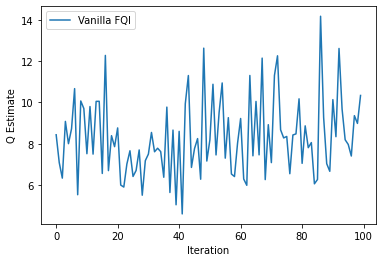

In [12]:
agent = FQIagent(train_tuples=train, test_tuples=test, weights=[1, 100, 1, 1, 1])
Q_dist = agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "Vanilla FQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()